**Цель блокнота - освоить три основных способа комбинации стратегий. Этот блокнот является продолжением и продвинутой версией классических стратегий (CS, TS и SmartBeta). Если есть пробелы, то лучше сперва изучить блокнот timeseries_smartbeta.ipynb**:

1) Решение принимается на основе двух факторов в разных долях. Например, 50% денег в Momentum, 50% в Value;

2) Двойная сортировка. Берем 20% лучших акций с самой низкой капитализацией, а потом из них 20% акций с наименьшим p/e;

3) Пересечение позиций. Покупаем акции, которые попали в портфель winners и для value и для momentum

# 1 - Импорт библиотек и загрузка данных

In [1]:
import pqr

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)

import os; os.chdir("..")
os.chdir('C:/Users/tomtosov/Desktop/data/countries_data/countries_data/csv/usa')

In [2]:
prices = pd.read_csv("close_price.csv", parse_dates=True, index_col=0)

mcap = pd.read_csv("mcap.csv", parse_dates=True, index_col=0)
pe = pd.read_csv("pe.csv", parse_dates=True, index_col=0)

volume = pd.read_csv("trading_volume.csv", parse_dates=True, index_col=0)
volume = prices * volume * 1000 # данные по объему из рефинитива даны в тыс. акций. Поэтому домножаем их на 1000 и на цену

prices, mcap, pe, volume = pqr.utils.replace_with_nan(prices, mcap, pe, volume)
prices, mcap, pe, volume = pqr.utils.align(prices, mcap, pe, volume)

# 2 - Настройка Universe, метрик и бенчмарков

Подробные комментарии для этих действий в предыдущем блокноте

In [4]:
universe = volume > 21_000_000 

Отслеживаем доходность

In [5]:
returns_calculator = pqr.utils.partial(
    pqr.calculate_returns, 
    universe_returns=pqr.prices_to_returns(prices),
)

Бенчмарк с равными весами. Пример другого способа взвешивания в предыдущем примере

In [6]:
ew_benchmark = pqr.Benchmark.from_universe(
    universe=universe,
    allocator=pqr.equal_weights,
    calculator=returns_calculator,
)

Все метрики для таблицы и график добавляем в дэшборд summary

In [22]:
table = pqr.metrics.Table()

table.add_metric( # начало всегда одинаковое
    pqr.utils.partial( # тут тоже без изменений
        pqr.metrics.mean_return, # название самой метрики
        statistics=True, # нужно ли отражать t-статистику и значимость* в таблицах
        annualizer=12, # аннуализируем месячную доходность в годовую (в году 12 месяцев, 52 недели и 252 дня)
    ),
    multiplier=100, # домножение на 100 для отображения на графиках
    name="Monthly Mean Return, %", # название в таблицах. ВАЖНО, чтобы не повторялось с другими метриками, иначе не отобразится
)

table.add_metric(
    pqr.utils.partial(
        pqr.metrics.volatility,
        annualizer=12,
    ),
    multiplier=100,
    name="Monthly Volatility, %",
)

table.add_metric(
    pqr.utils.partial(
        pqr.metrics.alpha,
        benchmark=ew_benchmark, # для относительных метрик указываем бенчмарк
        statistics=True,
        annualizer=12,
    ),
    multiplier=100,
    name="Alpha, %",
)

table.add_metric(
    pqr.utils.partial(
        pqr.metrics.sharpe_ratio,
    ),
    name="Sharpe Ratio, %",
)

table.add_metric(
    pqr.utils.partial(
        pqr.metrics.mean_turnover,
        annualizer=12,
    ),
    multiplier=100,
    name="Mean Turnover, %",
)

table.add_metric(
    pqr.utils.partial(
        pqr.metrics.win_rate,
    ),
    multiplier=100,
    name="Win Rate, %",
)

table.add_metric(
    pqr.utils.partial(
        pqr.metrics.max_drawdown,
    ),
    multiplier=100,
    name="Max Drawdown, %",
)

fig = pqr.metrics.Figure( # начало графика всегда одинаковое
    pqr.metrics.compounded_returns, # метрика для графика. Обязательно должна быть в виде ряда (trailing), а не точки 
    name="Compounded Returns", # название
    benchmark=ew_benchmark, # бенчмарк для наложения на график
    log_scale=True, # нужна ли лог шкала. Используйте, когда разность в доходности портфелей так высока, что график нечитаем
)

summary = pqr.metrics.Dashboard([table, fig])

# 3 - Собираем факторы

Динамичные параметры для расчета моментума и динамики объема торгов с дизайном 6-0-6

In [23]:
dynamic_params = pqr.utils.compose(
    pqr.utils.partial(pqr.factors.filter, universe=universe),
    pqr.utils.partial(pqr.factors.look_back_pct_change, period=6),
    pqr.utils.partial(pqr.factors.lag, period=1),
    pqr.utils.partial(pqr.factors.hold, period=6),
)

Статичные параметры для расчета Value и Size 1-0-1. Просто покупаем наименьший pe предыдущего периода и держим один период

In [24]:
static_params = pqr.utils.compose(
    pqr.utils.partial(pqr.factors.filter, universe=universe),
    pqr.utils.partial(pqr.factors.look_back_mean, period=0),
    pqr.utils.partial(pqr.factors.lag, period=1),
    pqr.utils.partial(pqr.factors.hold, period=1),
)

Применяем

In [25]:
momentum_factor = dynamic_params(prices)
volume_factor = dynamic_params(volume)

In [26]:
size_factor = static_params(mcap)
value_factor = static_params(pe)

Сначала строим однофакторные портфели экономным способом через задание нужных квантилей напрямую

,Value,Size
"Monthly Mean Return, %",12.71*** (4.50),14.90*** (3.93)
"Monthly Volatility, %",19.68,26.45
"Alpha, %",1.50 (1.26),-0.88 (-0.75)
"Sharpe Ratio, %",0.65,0.56
"Mean Turnover, %",685.61,915.76
"Win Rate, %",62.09,59.01
"Max Drawdown, %",-60.49,-57.52


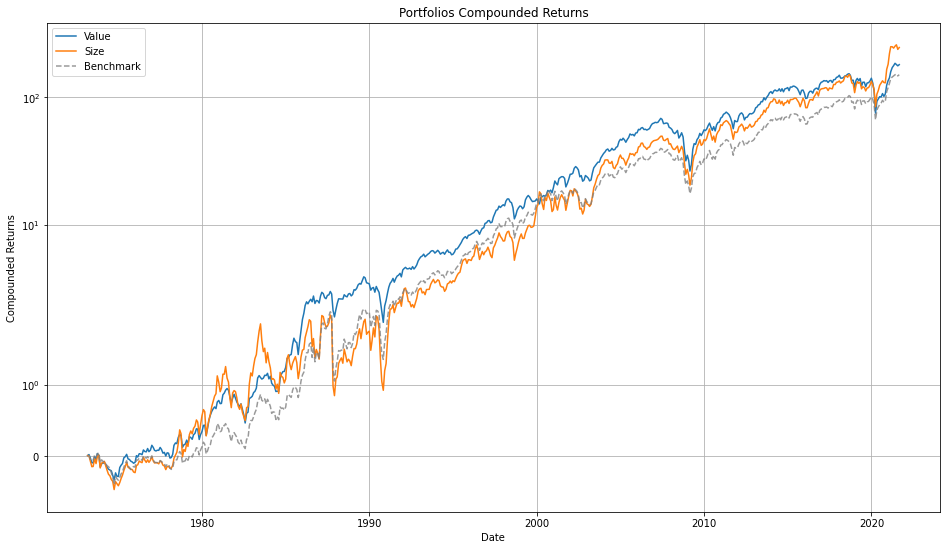

In [27]:
value_portfolio = pqr.Portfolio.backtest(
    longs=pqr.factors.quantiles(value_factor, min_q=0.0, max_q=0.2), # от наименьшего значения к наибольшему
    shorts=None,
    allocator=pqr.equal_weights,
    calculator=returns_calculator,
    name="Value",
)

size_portfolio = pqr.Portfolio.backtest(
    longs=pqr.factors.quantiles(size_factor, min_q=0.0, max_q=0.2),
    shorts=None,
    allocator=pqr.equal_weights,
    calculator=returns_calculator,
    name="Size",
)

summary.display([value_portfolio, size_portfolio])

Этот способ аналогичен нарезанию выборки на 5 квантилей и отбором лучшего из них. 

In [28]:
value_p = pqr.factors.backtest_factor_portfolios(
    factor=value_factor, # на основе чего принимаем решения (матрица или таблица)
    strategies=pqr.factors.split_quantiles(5, better='less'), # split_quantiles - означает нарезку выборки на х% акций
    allocator=pqr.equal_weights, # веса равные
    calculator=returns_calculator, # откуда тянем доходность для оценки портфеля
    add_wml=False, # нужен ли арбитражный портфель
)

size_p = pqr.factors.backtest_factor_portfolios(
    factor=size_factor, # на основе чего принимаем решения (матрица или таблица)
    strategies=pqr.factors.split_quantiles(5, better='less'), # split_quantiles - означает нарезку выборки на х% акций
    allocator=pqr.equal_weights, # веса равные
    calculator=returns_calculator, # откуда тянем доходность для оценки портфеля
    add_wml=False, # нужен ли арбитражный портфель
)

,Winners,Winners
"Monthly Mean Return, %",14.90*** (3.93),12.71*** (4.50)
"Monthly Volatility, %",26.45,19.68
"Alpha, %",-0.88 (-0.75),1.50 (1.26)
"Sharpe Ratio, %",0.56,0.65
"Mean Turnover, %",915.76,685.61
"Win Rate, %",59.01,62.09
"Max Drawdown, %",-57.52,-60.49


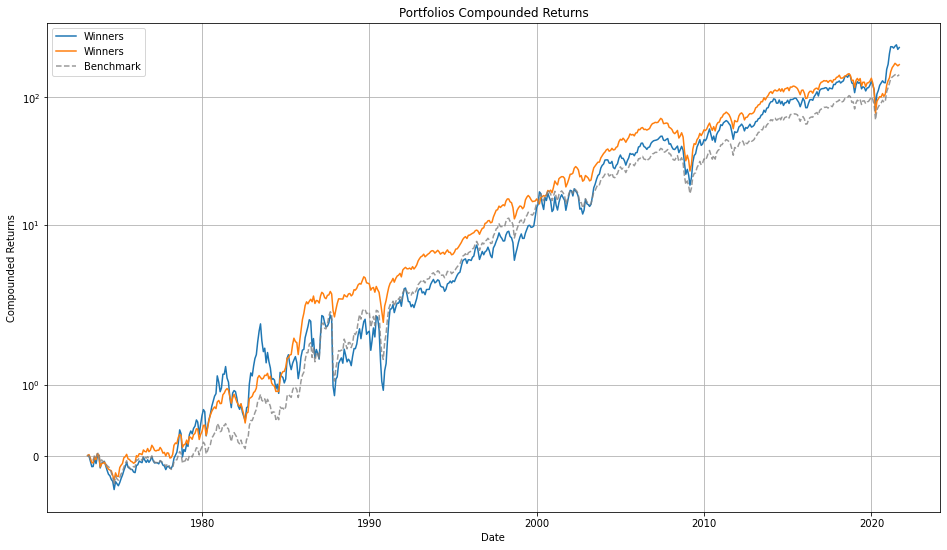

In [29]:
summary.display([size_p[0], value_p[0]])

# Weighted Multifactor

Закладываем по 50% капитала в каждую стратегию. Недостаток данного способа в том, что пока есть возможность указать только единый квантиль

,Value,Size,Value + size Weighted
"Monthly Mean Return, %",12.71*** (4.50),14.90*** (3.93),13.40*** (4.00)
"Monthly Volatility, %",19.68,26.45,23.36
"Alpha, %",1.50 (1.26),-0.88 (-0.75),-0.54 (-0.53)
"Sharpe Ratio, %",0.65,0.56,0.57
"Mean Turnover, %",685.61,915.76,898.77
"Win Rate, %",62.09,59.01,59.35
"Max Drawdown, %",-60.49,-57.52,-54.61


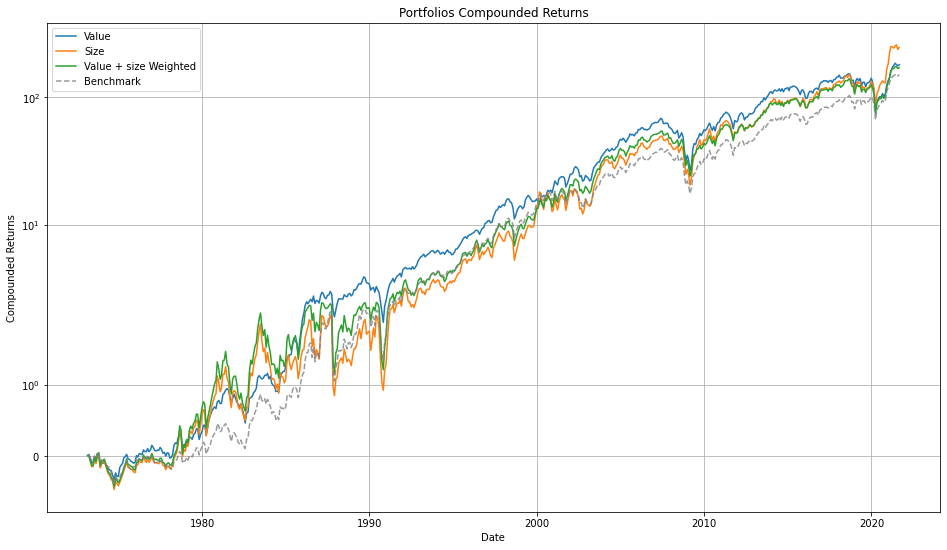

In [30]:
value_size_weighted_portfolio = pqr.Portfolio.backtest(
    longs=pqr.factors.quantiles(0.5 * value_factor + 0.5 * size_factor, min_q=0.0, max_q=0.2),
    shorts=None,
    allocator=pqr.equal_weights,
    calculator=returns_calculator,
    name="Value + size Weighted"
)

summary.display([value_portfolio, size_portfolio, value_size_weighted_portfolio])

# Intersection Multifactor

Ищем пересечения в портфелях и покупаем только те бумаги, которые попали в 20% лучших для обоих стратегий

,Value,Size,Value + size Weighted,Value + Size Intersection
"Monthly Mean Return, %",12.71*** (4.50),14.90*** (3.93),13.40*** (4.00),15.80*** (4.19)
"Monthly Volatility, %",19.68,26.45,23.36,26.28
"Alpha, %",1.50 (1.26),-0.88 (-0.75),-0.54 (-0.53),1.43 (0.77)
"Sharpe Ratio, %",0.65,0.56,0.57,0.60
"Mean Turnover, %",685.61,915.76,898.77,1284.21
"Win Rate, %",62.09,59.01,59.35,57.98
"Max Drawdown, %",-60.49,-57.52,-54.61,-67.86


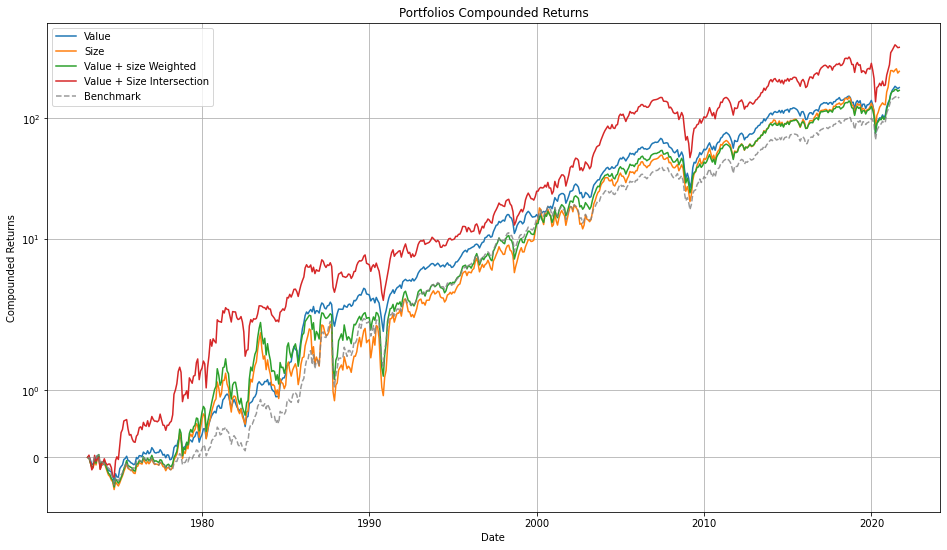

In [31]:
value_size_intercept_portfolio = pqr.Portfolio.backtest(
    longs=pqr.factors.quantiles(value_factor, min_q=0.0, max_q=0.2) & 
            pqr.factors.quantiles(size_factor, min_q=0.0, max_q=0.2),
    shorts=None,
    allocator=pqr.equal_weights,
    calculator=returns_calculator,
    name="Value + Size Intersection",
)

summary.display([
    value_portfolio, 
    size_portfolio, 
    value_size_weighted_portfolio, 
    value_size_intercept_portfolio
])

Количество акций в value

In [35]:
(value_portfolio.holdings>0).sum(axis=1).mean()

218.07718696397941

<AxesSubplot:xlabel='Value'>

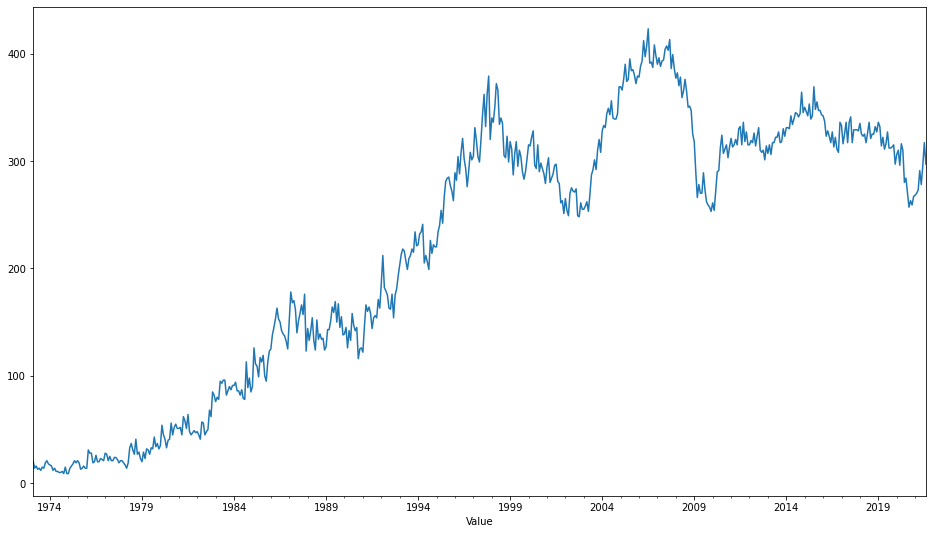

In [32]:
(value_portfolio.holdings>0).sum(axis=1).plot()

Количество акций в пересеченном портфеле

In [33]:
(value_size_intercept_portfolio.holdings>0).sum(axis=1).mean()

40.732418524871356

<AxesSubplot:xlabel='Value + Size Intersection'>

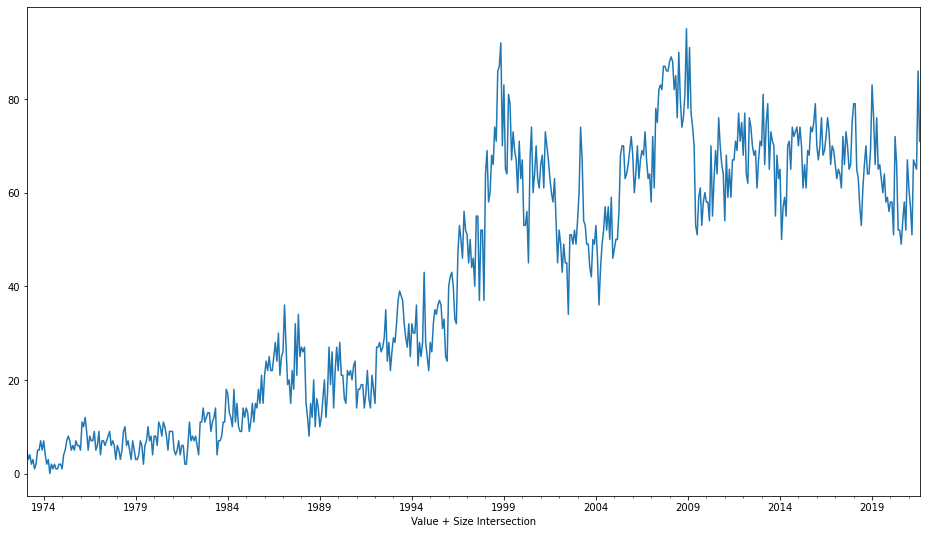

In [34]:
(value_size_intercept_portfolio.holdings>0).sum(axis=1).plot()

# Double Sorting Multifactor

In [37]:
def double_sort(f1, f2): # переменные на вход - это факторы. f1 важнее (включает больше акций для отбора), чем f2
    
    return pqr.factors.quantiles( 
        pqr.factors.filter(f2, universe=pqr.factors.quantiles(f1, min_q=0.0, max_q=0.2)), # квантили f1
        min_q=0, # начало квантилей f2
        max_q=0.2, # продолжение квантиля f2
    )

In [38]:
size_value_double_sort_portfolio = pqr.Portfolio.backtest(
    longs=double_sort(size_factor, value_factor), # функция двойной сортировки возникает здесь
    shorts=None,
    allocator=pqr.equal_weights,
    calculator=returns_calculator,
    name="Size -> Value Double Sort",
)

In [39]:
value_size_double_sort_portfolio = pqr.Portfolio.backtest(
    longs=double_sort(value_factor, size_factor),
    shorts=None,
    allocator=pqr.equal_weights,
    calculator=returns_calculator,
    name="Value -> Size Double Sort",
)

,Size,Value,Value + size Weighted,Value + Size Intersection,Size -> Value Double Sort,Value -> Size Double Sort
"Monthly Mean Return, %",14.90*** (3.93),12.71*** (4.50),13.40*** (4.00),15.80*** (4.19),14.51*** (3.74),15.58*** (4.30)
"Monthly Volatility, %",26.45,19.68,23.36,26.28,27.03,25.28
"Alpha, %",-0.88 (-0.75),1.50 (1.26),-0.54 (-0.53),1.43 (0.77),-0.23 (-0.12),1.63 (0.94)
"Sharpe Ratio, %",0.56,0.65,0.57,0.60,0.54,0.62
"Mean Turnover, %",915.76,685.61,898.77,1284.21,1268.46,1235.40
"Win Rate, %",59.01,62.09,59.35,57.98,57.46,58.83
"Max Drawdown, %",-57.52,-60.49,-54.61,-67.86,-69.53,-69.21


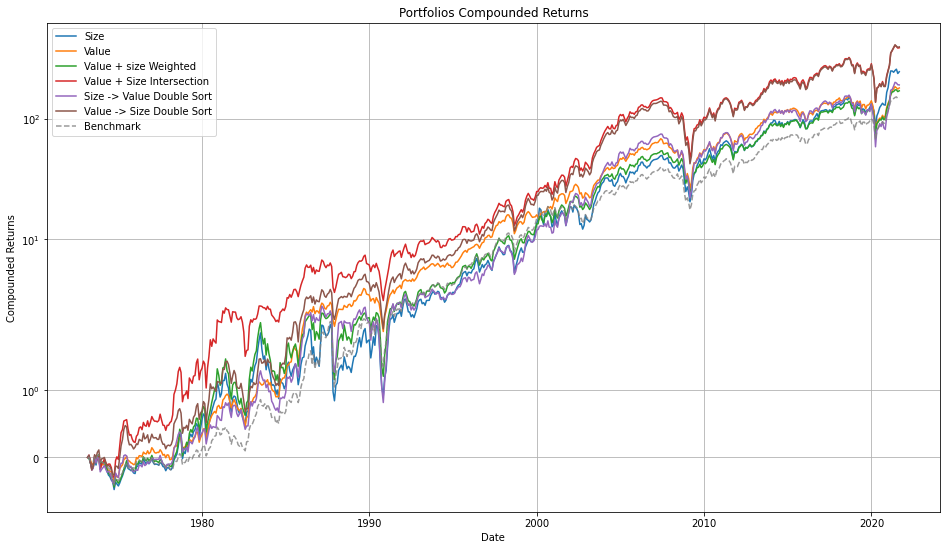

In [40]:
summary.display([
    size_portfolio, value_portfolio, 
    value_size_weighted_portfolio, 
    value_size_intercept_portfolio,
    size_value_double_sort_portfolio,
    value_size_double_sort_portfolio
])

In [42]:
(value_size_double_sort_portfolio.holdings>0).sum(axis=1).mean()

44.0377358490566

<AxesSubplot:xlabel='Value -> Size Double Sort'>

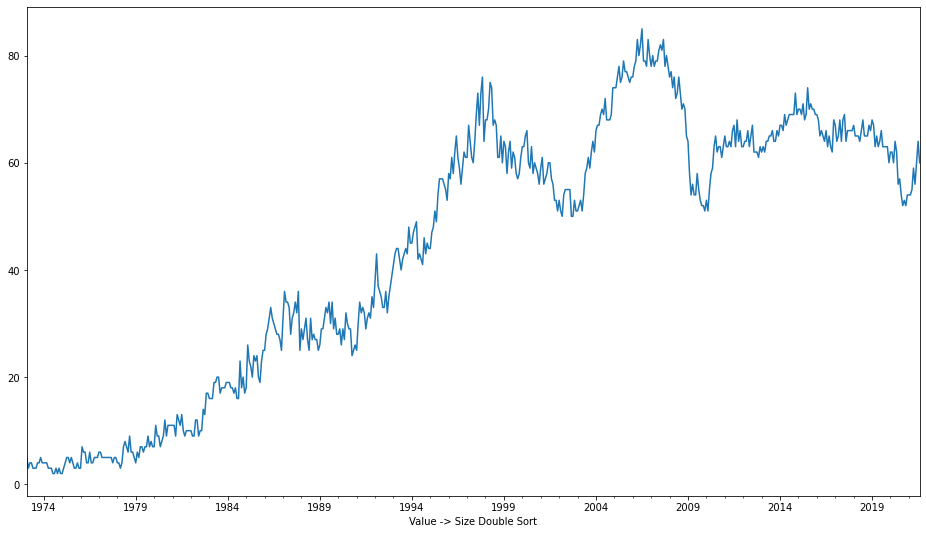

In [41]:
(value_size_double_sort_portfolio.holdings>0).sum(axis=1).plot()